# <span style="color:navy"> Extract Text Information from 10-K 


In this notebook we will crawl 10-K from SEC, extract item 1 in 10-K and use key word frequency analysis to evaluate the company.

# <span style="color:navy"> STEP 1 : Get Apple's [AAPL] 2020 10-K 

We will use Apple's 10-K as an example here. The code we are using to crawl and extract item1 from 10-K is generic and can be used for other companies. 
 
[SEC Website URL for 10-K (TEXT version)](https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/0000320193-20-000096.txt)

[SEC Website URL for 10-K (HTML version)](https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/aapl-20200926.htm)

You can get 10-K for other companies via [SEC's search tool](https://www.sec.gov/cgi-bin/browse-edgar?CIK=0000320193&owner=exclude&action=getcompany&Find=Search)

In [210]:
# Import requests to retrive Web Urls example HTML. TXT 
import requests

# Get the HTML data from the 2020 10-K from Apple
r = requests.get('https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/0000320193-20-000096.txt')
raw_10k = r.text

In [211]:
print(raw_10k[0:1500])

<SEC-DOCUMENT>0000320193-20-000096.txt : 20201030
<SEC-HEADER>0000320193-20-000096.hdr.sgml : 20201030
<ACCEPTANCE-DATETIME>20201029180625
ACCESSION NUMBER:		0000320193-20-000096
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		99
CONFORMED PERIOD OF REPORT:	20200926
FILED AS OF DATE:		20201030
DATE AS OF CHANGE:		20201029

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			Apple Inc.
		CENTRAL INDEX KEY:			0000320193
		STANDARD INDUSTRIAL CLASSIFICATION:	ELECTRONIC COMPUTERS [3571]
		IRS NUMBER:				942404110
		STATE OF INCORPORATION:			CA
		FISCAL YEAR END:			0926

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-36743
		FILM NUMBER:		201273977

	BUSINESS ADDRESS:	
		STREET 1:		ONE APPLE PARK WAY
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014
		BUSINESS PHONE:		(408) 996-1010

	MAIL ADDRESS:	
		STREET 1:		ONE APPLE PARK WAY
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	APPLE INC
		DATE OF NAME CHANG

# <span style="color:navy"> STEP 2 : Get document from the downloaded 10-K file
    
For our purposes, we are only interested in the sections that contain the 10-K information. All the sections, including the 10-K are contained within the <DOCUMENT> and </DOCUMENT> tags. Each section within the document tags is clearly marked by a <TYPE> tag followed by the name of the section.


In [212]:
# Regex to find <DOCUMENT> tags
doc_start_pattern = re.compile(r'<DOCUMENT>')
doc_end_pattern = re.compile(r'</DOCUMENT>')
# Regex to find <TYPE> tag prceeding any characters, terminating at new line
type_pattern = re.compile(r'<TYPE>[^\n]+')


# Create 3 lists with the span idices for each regex

### There are many <Document> Tags in this text file, each as specific exhibit like 10-K, EX-10.17 etc
### First filter will give us document tag start <end> and document tag end's <start> 
### We will use this to later grab content in between these tags
doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

### Type filter is interesting, it looks for <TYPE> with Not flag as new line, ie terminare there, with + sign
### to look for any char afterwards until new line \n. This will give us <TYPE> followed Section Name like '10-K'
### Once we have have this, it returns String Array, below line will with find content after <TYPE> ie, '10-K' 
### as section names
doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

document = {}

# Create a loop to go through each section type and save only the 10-K section in the dictionary
for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
    if doc_type == '10-K':
        document[doc_type] = raw_10k[doc_start:doc_end]

In [213]:
# display excerpt the document
document['10-K'][0:500]

'\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>aapl-20200926.htm\n<DESCRIPTION>10-K\n<TEXT>\n<XBRL>\n<?xml version="1.0" ?><!--XBRL Document Created with Wdesk from Workiva--><!--Copyright 2020 Workiva--><!--r:5595bda7-992d-4241-bfcc-976a7edbf862,g:a71cbd11-d0c6-4466-a60e-9f48342467d1,d:ef781ab58e4f4fcaa872ddbd30da40e1--><html xmlns:xbrldi="http://xbrl.org/2006/xbrldi" xmlns:iso4217="http://www.xbrl.org/2003/iso4217" xmlns="http://www.w3.org/1999/xhtml" xmlns:srt="http://fasb.org/srt/2020-01-31" xmlns:ixt-sec="h'

# <span style="color:navy"> STEP 2 (OPTIONAL): using Python regular expression to automatically extract section Item 1. from 10-K

You can manually extract item1 from downloaded 10-K files, or you can use the following method to automatically extract item1.    
    
10-K item1 can be found in either of the following patterns:

1. `>Item 1.`

2. `>Item&#160;1.` 

3. `>Item&nbsp;1.`

4. `ITEM 1.` 

In the code below we will write a single regular expression that can match all four patterns for Item 1, Item 2 and then use the `.finditer()` method to match the regex to `document['10-K']`.
    
As the item1, item2 appears in indexes, we need to sort all matches of item1 and item2 and use the words between last pair of item1 and item2 as the actual item1 text. 


In [214]:
import re

# Create the regular expression for the above cases
regex = re.compile(r'((>)*I(tem|TEM)(\s|&#160;|&nbsp;|&#xa0;)(1|2)\.(\s|&#160;|&nbsp;|<))')

# Use finditer to math the regex
matches = regex.finditer(document['10-K'])

# Create the dataframe
test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

test_df.columns = ['item', 'start', 'end']
test_df['item'] = test_df.item.str.lower()

# Get rid of unnesesary charcters from the dataframe
test_df.replace('&#160;',' ',regex=True,inplace=True)
test_df.replace('&nbsp;',' ',regex=True,inplace=True)
test_df.replace(' ','',regex=True,inplace=True)
test_df.replace('\.','',regex=True,inplace=True)
test_df.replace('>','',regex=True,inplace=True)

# Display the dataframe
test_df.head()

# Drop duplicates
pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')

# Set item as the dataframe index
pos_dat.set_index('item', inplace=True)

# Display the dataframe
pos_dat

# Get raw Item 1 (with HTML tags)
item_1_raw = document['10-K'][pos_dat['start'].loc['item1']:pos_dat['start'].loc['item2']]

# Extract the clear item1 text from HTML using Python BeautifulSoup library
item_1_content = BeautifulSoup(item_1_raw, 'lxml')
item1_text = item_1_content.get_text("\n\n")

#DISPLAY first 1000 characters of ITEM 1
print(item1_text[0:1000])

>Item 1.    Business

Company Background

The Company designs, manufactures and markets smartphones, personal computers, tablets, wearables and accessories, and sells a variety of related services. The Company’s fiscal year is the 52- or 53-week period that ends on the last Saturday of September. The Company is a California corporation established in 1977.

Products

iPhone

iPhone

®

 is the Company’s line of smartphones based on its iOS operating system. During 2020, the Company released a new iPhone SE. In October 2020, the Company announced four new iPhone models with 5G technology: iPhone 12 and iPhone 12 Pro were available starting in October 2020, and iPhone 12 Pro Max and iPhone 12 mini are both expected to be available in November 2020.

Mac

Mac

®

 is the Company’s line of personal computers based on its macOS

®

 operating system. During 2020, the Company released a new 16-inch MacBook Pro

®

, a fully redesigned Mac Pro

®

, and updated versions of its MacBook Air

®


# <span style="color:navy"> STEP 3: Counting Word Patterns in Item1 Using Regular Expressions
We use the word lists from the paper "Stuck in the middle? Using the exploration-exploitation lens to resolve the generic strategy debate":
    
* **Strategic positioning**: differenti\*, unique\*, superior\*, premium\*, excellen\*, leading edge, upscale, high\* price\*,
high\* margin\*, high\* end\*, inelasticity\*, cost leader\*, low\* pric\*, low\* cost\*, cost advantage\*, competitive
pric\*, aggressive pric\*
* **Operations**: efficien\*, high\* yield\*, process\* improvement\*, asset\* utilization\*, capacity\* utilization\*, scope\*,
scale\*, breath\*, broad, mass, high\* volume\*, large\* volume\*, economy\* of scale, new\* product\*, quality\*,
reliab\*, durable\*
* **Marketing**: marketing\*, advertis\*, brand\*, reputation\*, trademark\*
* **Service**: customer\* service\*, consumer\* service\*, customer\* need\*, sales support\*, post-purchase service\*,
customer\* preference\*, consumer\* preference\*, consumer\* relation\*, consumer\* experience\*, consumer\*
support\*, loyalty\*, customiz\*, tailor\*, personaliz\*, responsive\*, on time, timely
* **Technology**: innovate\*, creativ\*, research and development, R&D, techni*, technolog\*, patent\*, proprietar\*
* **Infrastructure**: control\* cost\*, control\* expense\*, control\* overhead\*, minimiz\* cost\*, minimiz\* expense\*,
minimiz\* overhead\*, reduce\* cost\*, reduce\* expense\*, reduce\* overhead\*, cut\* cost\*, cut\* expense\*, cut\*
overhead\*, decreas\* cost\*, decreas\* expense\*, decreas\* overhead\*, monitor\* cost\*, monitor\* expense\*,
monitor\* overhead\*, sav\* cost\*, sav\* expense\*, sav\* overhead\*, cost\* control\*, cost\* minimization\*, cost\*
reduction\*, cost\* saving\*, cost\* improvement\*, expense\* control\*, expense\* minimization\*, expense\*
reduction\*, expense\* saving\*, expense\* improvement\*, overhead\* control\*, overhead\* minimization\*,
overhead\* reduction\*, overhead\* saving\*, overhead\* improvement\*    
* **Human resources management**: talent\*, train\*, skill\*, intellectual propert\*, human capital\*

### Create Python Regular Expression for Each Word in the Word List

In [215]:
import re

regexes = [
	"\\bdifferenti\w*\\b",
	"\\bunique\w*\\b",
	"\\bsuperior\w*\\b",
	"\\bpremium\w*\\b",
	"\\bexcellen\w*\\b",
	"\\bleading\s+edge\\b",
	"\\bupscale\\b",
	"\\bhigh\w*\s+price\w*\\b",
	"\\bhigh\w*\s+margin\w*\\b",
	"\\bhigh\w*\s+end\w*\\b",
	"\\binelasticity\w*\\b",
	"\\bcost\s+leader\w*\\b",
	"\\blow\w*\s+pric\w*\\b",
	"\\blow\w*\s+cost\w*\\b",
	"\\bcost\s+advantage\w*\\b",
	"\\bcompetitive\s+pric\w*\\b",
	"\\baggressive\s+pric\w*\\b",
	"\\befficien\w*\\b",
	"\\bhigh\w*\s+yield\w*\\b",
	"\\bprocess\w*\s+improvement\w*\\b",
	"\\basset\w*\s+utilization\w*\\b",
	"\\bcapacity\w*\s+utilization\w*\\b",
	"\\bscope\w*\\b",
	"\\bscale\w*\\b",
	"\\bbreath\w*\\b",
	"\\bbroad\\b",
	"\\bmass\\b",
	"\\bhigh\w*\s+volume\w*\\b",
	"\\blarge\w*\s+volume\w*\\b",
	"\\beconomy\w*\s+of\s+scale\\b",
	"\\bnew\w*\s+product\w*\\b",
	"\\bquality\w*\\b",
	"\\breliab\w*\\b",
	"\\bdurable\w*\\b",
	"\\bmarketing\w*\\b",
	"\\badvertis\w*\\b",
	"\\bbrand\w*\\b",
	"\\breputation\w*\\b",
	"\\btrademark\w*\\b",
	"\\bcustomer\w*\s+service\w*\\b",
	"\\bconsumer\w*\s+service\w*\\b",
	"\\bcustomer\w*\s+need\w*\\b",
	"\\bsales\s+support\w*\\b",
	"\\bpost-purchase\s+service\w*\\b",
	"\\bcustomer\w*\s+preference\w*\\b",
	"\\bconsumer\w*\s+preference\w*\\b",
	"\\bconsumer\w*\s+relation\w*\\b",
	"\\bconsumer\w*\s+experience\w*\\b",
	"\\bconsumer\w*\s+support\w*\\b",
	"\\bloyalty\w*\\b",
	"\\bcustomiz\w*\\b",
	"\\btailor\w*\\b",
	"\\bpersonaliz\w*\\b",
	"\\bresponsive\w*\\b",
	"\\bon\s+time\\b",
	"\\btimely\\b",
	"\\binnovate\w*\\b",
	"\\bcreativ\w*\\b",
	"\\bresearch\s+and\s+development\\b",
	"\\br&d\\b",
	"\\btechni\w*\\b",
	"\\btechnolog\w*\\b",
	"\\bpatent\w*\\b",
	"\\bproprietar\w*\\b",
	"\\bcontrol\w*\s+cost\w*\\b",
	"\\bcontrol\w*\s+expense\w*\\b",
	"\\bcontrol\w*\s+overhead\w*\\b",
	"\\bminimiz\w*\s+cost\w*\\b",
	"\\bminimiz\w*\s+expense\w*\\b",
	"\\bminimiz\w*\s+overhead\w*\\b",
	"\\breduce\w*\s+cost\w*\\b",
	"\\breduce\w*\s+expense\w*\\b",
	"\\breduce\w*\s+overhead\w*\\b",
	"\\bcut\w*\s+cost\w*\\b",
	"\\bcut\w*\s+expense\w*\\b",
	"\\bcut\w*\s+overhead\w*\\b",
	"\\bdecreas\w*\s+cost\w*\\b",
	"\\bdecreas\w*\s+expense\w*\\b",
	"\\bdecreas\w*\s+overhead\w*\\b",
	"\\bmonitor\w*\s+cost\w*\\b",
	"\\bmonitor\w*\s+expense\w*\\b",
	"\\bmonitor\w*\s+overhead\w*\\b",
	"\\bsav\w*\s+cost\w*\\b",
	"\\bsav\w*\s+expense\w*\\b",
	"\\bsav\w*\s+overhead\w*\\b",
	"\\bcost\w*\s+control\w*\\b",
	"\\bcost\w*\s+minimization\w*\\b",
	"\\bcost\w*\s+reduction\w*\\b",
	"\\bcost\w*\s+saving\w*\\b",
	"\\bcost\w*\s+improvement\w*\\b",
	"\\bexpense\w*\s+control\w*\\b",
	"\\bexpense\w*\s+minimization\w*\\b",
	"\\bexpense\w*\s+reduction\w*\\b",
	"\\bexpense\w*\s+saving\w*\\b",
	"\\bexpense\w*\s+improvement\w*\\b",
	"\\boverhead\w*\s+control\w*\\b",
	"\\boverhead\w*\s+minimization\w*\\b",
	"\\boverhead\w*\s+reduction\w*\\b",
	"\\boverhead\w*\s+saving\w*\\b",
	"\\boverhead\w*\s+improvement\w*\\b",
	"\\btalent\w*\\b",
	"\\btrain\w*\\b",
	"\\bskill\w*\\b",
	"\\bintellectual\s+propert\w*\\b",
	"\\bhuman\s+capital\w*\\b",
	]


wordRegExpressions = []
for s in regexes:
    wordRegExpressions.append(re.compile(r"{}".format(s)))

# Categories of these words
categories = ["Strategic positioning","Operations","Marketing","Service","Technology","Infrastructure","Human resources management"]
category_index = [0,16, 33, 38, 55, 63, 99, 104]

# Extract word freqency from item1 text as a string
def extract_word_freq(item1_text):
    #convert to lower cases and strip all new lines
    item1_string_text = item1_text.lower().replace('\n', " ")
    item1_total_words = len(item1_string_text.split())

    #word_counts is an array of word counts for each word pattern
    word_counts = []
    word_freq   = []
    for regWord in wordRegExpressions:
        #get number of matches per word pattern
        matches = len(re.findall(regWord, item1_string_text))
        word_counts.append(matches)
        word_freq.append(matches/item1_total_words * 100)
    
    return word_counts, word_freq

# Extract category freqency from item1 text as a string
def extract_category_freq(item1_text):
    #convert to lower cases and strip all new lines
    item1_string_text = item1_text.lower().replace('\n', " ")
    item1_total_words = len(item1_string_text.split())

    #word_counts is an array of word counts for each word pattern
    word_counts = []
    for regWord in wordRegExpressions:
        #get number of matches per word pattern
        matches = len(re.findall(regWord, item1_string_text))
        word_counts.append(matches)
        
    category_sum = []
    category_freq = []

    #sum the word counts in each category 
    for i in range(len(categories)):
        category_total = sum(word_counts[category_index[i]:category_index[i+1]+1])
        category_sum.append(category_total)
        category_freq.append(category_total/item1_total_words * 100)
    
    return category_sum, category_freq

## STEP 4 Get Word Counts from the Extracted Item 1 Text
As we have compiled a list of word patterns. We will use regular expression matches to look for counts of these word patterns in item1.  
In python jupyter notebook, we can use pandas datafram library to print the word counts in a tabular way.

In [216]:
# call python function extract_word_freq to get the absolute word counts and frequency 
word_counts, word_freq = extract_word_freq(item1_text)

features = ['w{}'.format(i) for i in range(105)]
df_word_counts = pd.DataFrame([features[i], regexes[i], word_counts[i], word_freq[i]] for i in range(len(wordRegExpressions)))

df_word_counts.columns = ['Feature','Regular Expression for Word Pattern', 'Count', 'Frequency']
pd.set_option('display.max_rows', 120)
df_word_counts

,Feature,Regular Expression for Word Pattern,Count,Frequency
0,w0,\bdifferenti\w*\b,0,0.000000
1,w1,\bunique\w*\b,3,0.027928
2,w2,\bsuperior\w*\b,0,0.000000
3,w3,\bpremium\w*\b,0,0.000000
4,w4,\bexcellen\w*\b,0,0.000000
5,w5,\bleading\s+edge\b,0,0.000000
6,w6,\bupscale\b,0,0.000000
7,w7,\bhigh\w*\s+price\w*\b,0,0.000000
8,w8,\bhigh\w*\s+margin\w*\b,0,0.000000
9,w9,\bhigh\w*\s+end\w*\b,0,0.000000


### (optional) Visualize Word Counts in Bar Graph


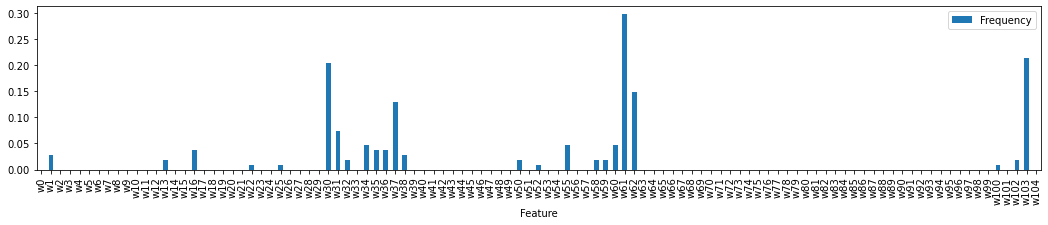

In [217]:
import matplotlib.pyplot as plt

df_word_counts.plot(x ='Feature', y='Frequency', kind = 'bar', figsize=(18,3))
plt.show()

## STEP 6 Group Word Frequency Based on Category 

We can group the word frequency based on 7 categories.

In [218]:
# Call function extract_category_freq to get word frequencies for each Category
category_sum, category_freq = extract_category_freq(item1_text)

print("category sum:", category_sum)
print("category freq:", category_freq)

category sum: [9, 38, 30, 11, 62, 0, 26]
category freq: [0.0837832805808974, 0.3537516291193446, 0.27927760193632467, 0.10240178737665238, 0.5771737106684044, 0.0, 0.24204058834481476]


### (optional) Use Pandas Dataframe to Display Word Counts in Each Category
In python jupyter notebook, we can use pandas datafram library to print the category counts in a tabular way.

In [219]:
df_category = pd.DataFrame([categories[i], category_sum[i], category_freq[i] ] for i in range(len(categories)))

df_category.columns = ['Category', 'Count', 'Frequency']
df_category

,Category,Count,Frequency
0,Strategic positioning,9,0.083783
1,Operations,38,0.353752
2,Marketing,30,0.279278
3,Service,11,0.102402
4,Technology,62,0.577174
5,Infrastructure,0,0.000000
6,Human resources management,26,0.242041


### (optional) Visualize Word Counts in Each Category through Bar Graph

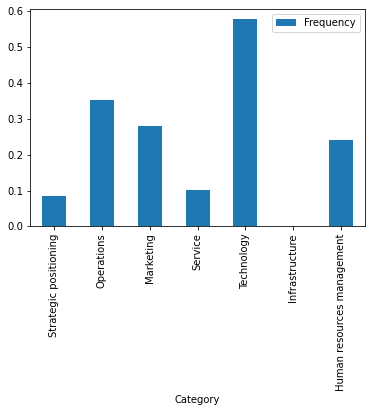

In [220]:
import matplotlib.pyplot as plt
df_category.plot(x ='Category', y='Frequency', kind = 'bar')
plt.show()

## STEP 7 Analyze Item1 Patterns from Different Years


We can download all 10-K files for a particular company, extract the item1 and apply the same word frequency analysis to check their pattern.
**From the bar graph, it can be seem that the 10-K files for a company follows the same pattern across different years.**

0000320193-19-000119.txt


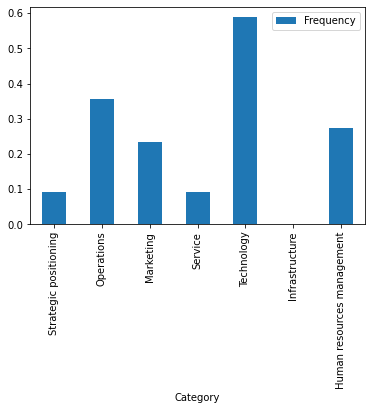

0001628280-16-020309.txt


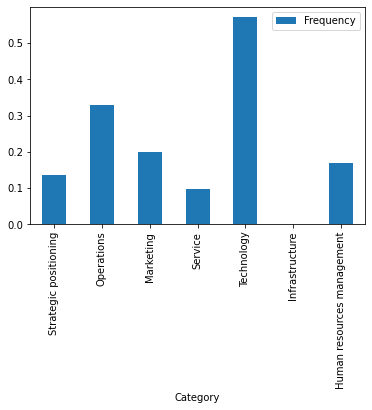

0000320193-17-000070.txt


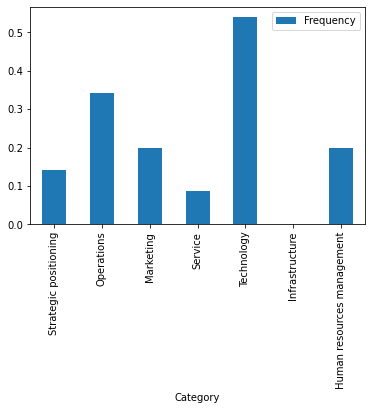

0001193125-10-238044.txt


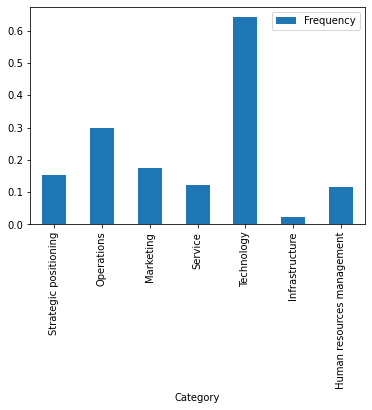

0001193125-14-383437.txt


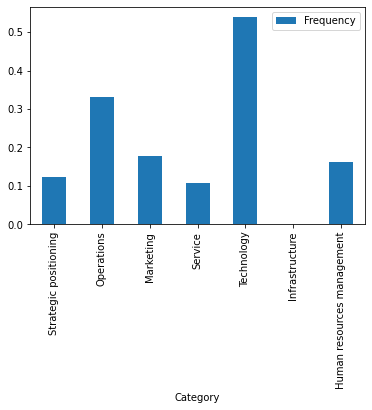

0001104659-05-058421.txt


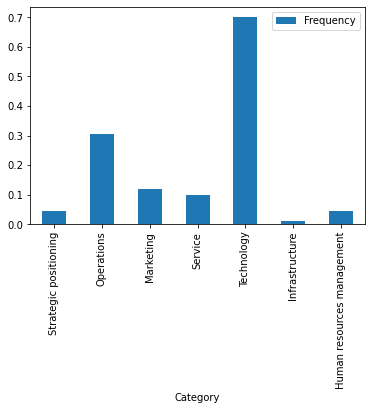

0001193125-11-282113.txt


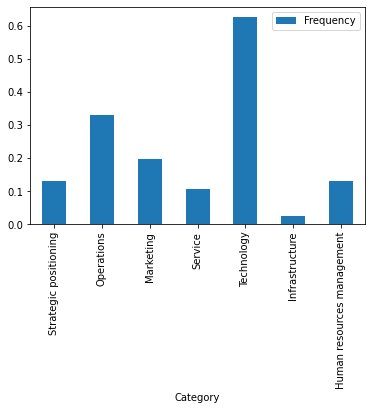

0001193125-09-214859.txt


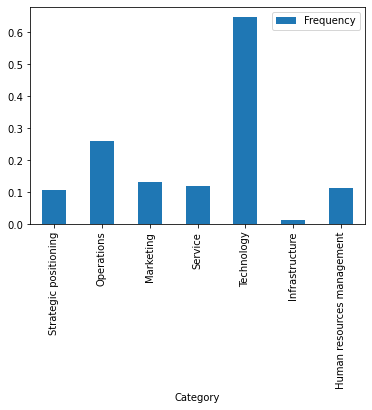

0000912057-00-053623.txt


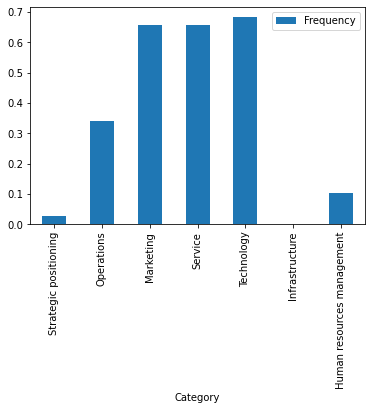

0001193125-12-444068.txt


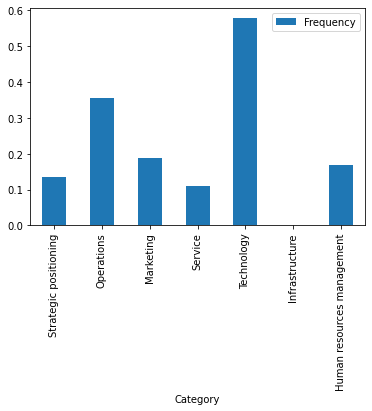

0001193125-08-224958.txt


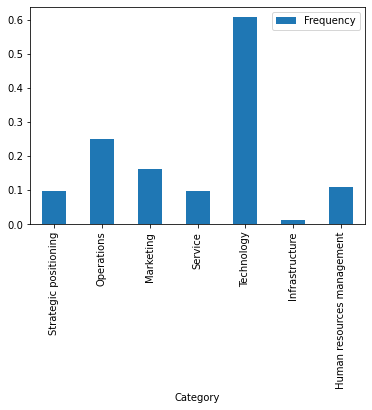

0001193125-15-356351.txt


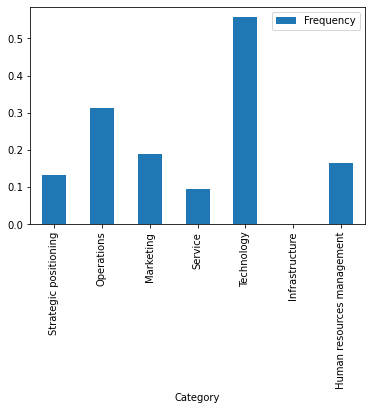

0000320193-20-000096.txt


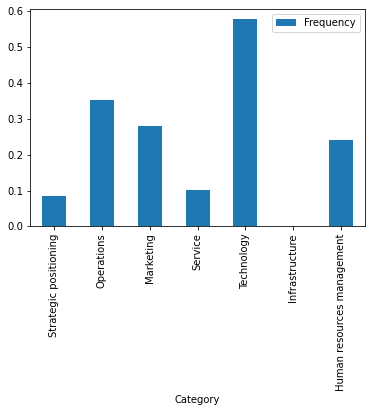

0000320193-18-000145.txt


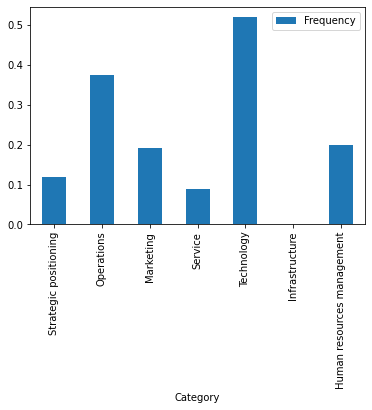

0001193125-13-416534.txt


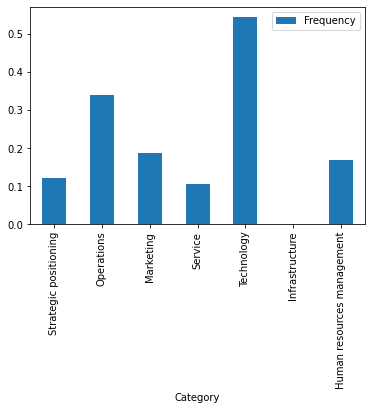

0001104659-06-084288.txt


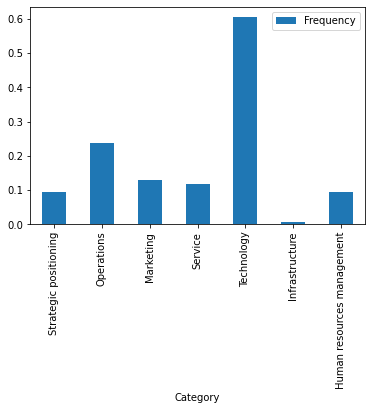

In [221]:
import os

#local directory where all item1 are located
working_dir = '../item1/'
#ticker
ticker = 'AAPL'

files = os.listdir(working_dir + ticker)
for file in files:
    print(file)
    item1_text = open(working_dir + ticker + '/' + file,'r').read()
    category_sum, category_freq = extract_category_freq(item1_text)
    #print("category sum:", category_sum)
    #print("category freq:", category_freq)
    df_category = pd.DataFrame([categories[i], category_freq[i] ] for i in range(len(categories)))
    df_category.columns = ['Category', 'Frequency']
    df_category.plot(x ='Category', y='Frequency', kind = 'bar')
    plt.show()

## STEP 8 Inference using Pre-Trained PCA Model Based on Word Frequency

We use the pre-trained coefficients from the paper "Stuck in the middle? Using the exploration-exploitation lens to resolve the generic strategy debate", Table 2: Rotated factor loading

In [222]:
#Product leadership
PCA_1 = {
61  :  0.6961 , # \btechnolog\w*\b
63  :  0.5113 , # \bproprietar\w*\b
103 :  0.4691 , # \bintellectual\s+propert\w*\b
62  :  0.4487 , # \bpatent\w*\b
60  :  0.3317 , # \btechni\w*\b
32  :  0.3285 , # \breliab\w*\b
30  :  0.3231 , # \bnew\w*\s+product\w*\b
}

#Customer intimacy
PCA_2 = {
36  :  0.549  , # \bbrand\w*\b
31  :  0.3613 , # \bquality\w*\b
34  :  0.3281 , # \bmarketing\w*\b
39  :  0.3276 , # \bcustomer\w*\s+service\w*\b
56  :  0.3079 , # \binnovate\w*\b
38  :  0.3022 , # \btrademark\w*\b
}

#Operationalexcellence
PCA_3 = {
70  :  0.3737 , # \breduce\w*\s+cost\w*\b
17  :  0.3684 , # \befficien\w*\b
13  :  0.3621 , # \blow\w*\s+cost\w*\b
89  :  0.3184 , # \bcost\w*\s+improvement\w*\b   
}

#Create coefficients vector for PCA component 1
PCA_1_coefficients = []
for index in range(105):
    if index in PCA_1.keys():
        PCA_1_coefficients.append(PCA_1[index])
    else:
        PCA_1_coefficients.append(0)
        
#Create coefficients vector for PCA component 2
PCA_2_coefficients = []
for index in range(105):
    if index in PCA_2.keys():
        PCA_2_coefficients.append(PCA_2[index])
    else:
        PCA_2_coefficients.append(0)
        
#Create coefficients vector for PCA component 3
PCA_3_coefficients = []
for index in range(105):
    if index in PCA_3.keys():
        PCA_3_coefficients.append(PCA_3[index])
    else:
        PCA_3_coefficients.append(0)

#Generate 3 vectors as 3 PCA component coefficients 
print(PCA_1_coefficients)
print(PCA_2_coefficients)
print(PCA_3_coefficients)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3231, 0, 0.3285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3317, 0.6961, 0.4487, 0.5113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4691, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3613, 0, 0, 0.3281, 0, 0.549, 0, 0.3022, 0.3276, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3079, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3621, 0, 0, 0, 0.3684, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3737, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3184, 0, 0, 0, 0, 0

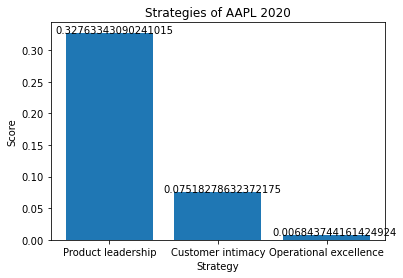

In [230]:
import numpy as np
# call python function extract_word_freq to get the absolute word counts and frequency 

def generate_strategy(word_freq):
    PCA_1 = np.dot(word_freq, PCA_1_coefficients)
    PCA_2 = np.dot(word_freq, PCA_2_coefficients)
    PCA_3 = np.dot(word_freq, PCA_3_coefficients)

    return PCA_1, PCA_2, PCA_3

def plot_strategy(PCA1, PCA2, PCA3, ticker, year):
    fig = plt.figure()
    strategy = ['Product leadership','Customer intimacy', 'Operational excellence']
    scores = [PCA1, PCA2, PCA3]
    plt.bar(strategy, scores)
    plt.xlabel("Strategy")
    plt.ylabel("Score")
    plt.title("Strategies of " + ticker + " 20" + year)
    xlocs=[0, 1, 2]
    for i, v in enumerate(scores):
        plt.text(xlocs[i] - 0.5, v, str(v))
    plt.show()

word_counts, word_freq = extract_word_freq(item1_text)    
PCA_1, PCA_2, PCA_3 = generate_strategy(word_freq)
plot_strategy(PCA_1, PCA_2, PCA_3, "AAPL", "20")

## STEP 9 Generate Strategy For Different Companies

[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 2, 1, 2, 0, 8, 0, 1, 0, 0, 11, 9, 6, 0, 2, 0, 5, 6, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 7, 0, 1, 0, 0, 2, 17, 5, 8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 14, 0]


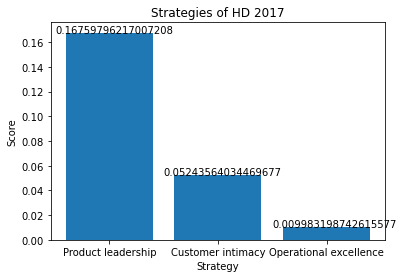

[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 2, 1, 2, 0, 8, 0, 1, 0, 0, 9, 9, 6, 0, 2, 0, 4, 6, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 7, 0, 1, 0, 0, 2, 17, 5, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 13, 0]


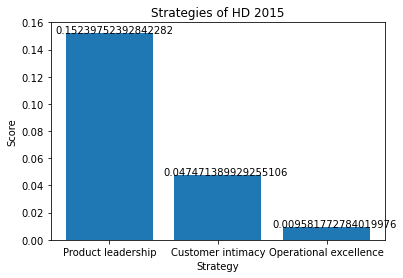

[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 1, 1, 2, 0, 6, 0, 1, 0, 0, 11, 9, 5, 0, 1, 0, 5, 4, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 7, 0, 0, 0, 0, 2, 18, 4, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 13, 0]


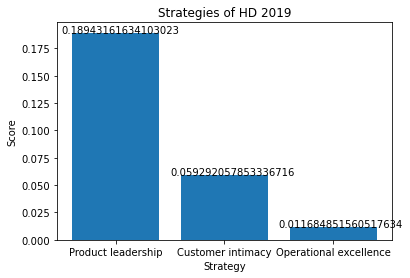

[0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 2, 1, 2, 0, 8, 0, 1, 0, 0, 8, 9, 7, 0, 2, 0, 3, 6, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 7, 0, 2, 0, 0, 2, 16, 5, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 13, 0]


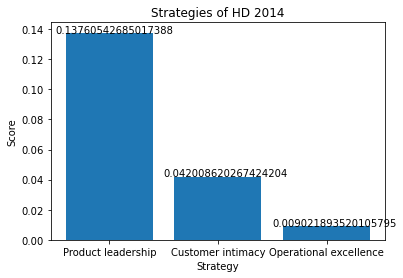

[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 2, 1, 2, 0, 8, 0, 1, 0, 0, 11, 9, 6, 0, 2, 0, 5, 6, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 7, 0, 1, 0, 0, 2, 17, 5, 8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 14, 0]


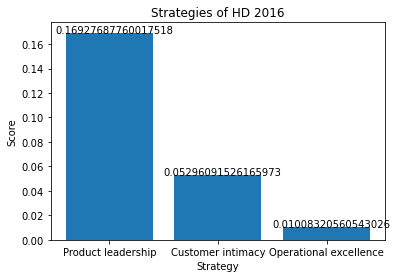

[3, 3, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 11, 0, 0, 1, 0, 10, 5, 2, 11, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 16, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0]


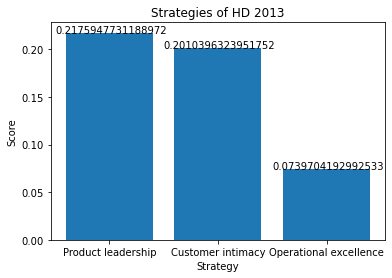

[4, 3, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 11, 0, 0, 1, 0, 13, 8, 2, 12, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 2, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 16, 2, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 2, 0]


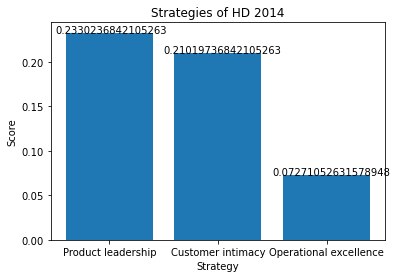

[8, 5, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 10, 0, 0, 4, 2, 13, 13, 2, 5, 0, 3, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 17, 2, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 2, 0]


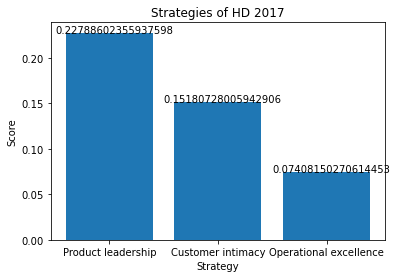

[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 1, 1, 2, 0, 7, 0, 1, 0, 0, 11, 9, 6, 0, 2, 0, 5, 6, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 7, 0, 1, 0, 0, 2, 17, 5, 8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 14, 0]


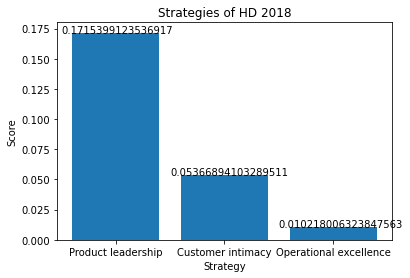

[8, 2, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 15, 2, 0, 7, 2, 15, 16, 2, 3, 0, 7, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 7, 1, 0, 8, 2, 0, 0, 0, 0, 27, 2, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 2, 0]


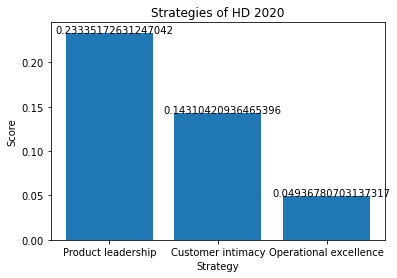

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


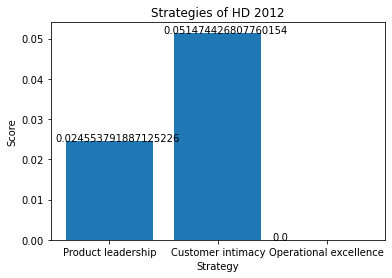

[8, 4, 2, 3, 7, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 15, 3, 0, 8, 2, 22, 27, 4, 4, 0, 5, 0, 0, 1, 2, 0, 0, 0, 1, 1, 2, 6, 2, 0, 9, 0, 0, 0, 0, 2, 28, 8, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 4, 3, 3]


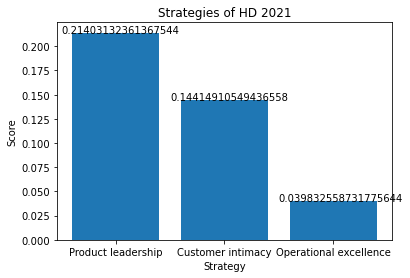

[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 2, 3, 0, 6, 0, 1, 0, 0, 11, 9, 5, 0, 1, 0, 4, 5, 10, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 7, 0, 0, 0, 0, 2, 13, 4, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 1, 13, 0]


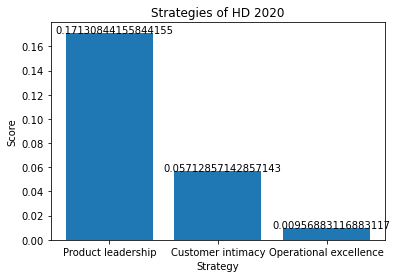

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


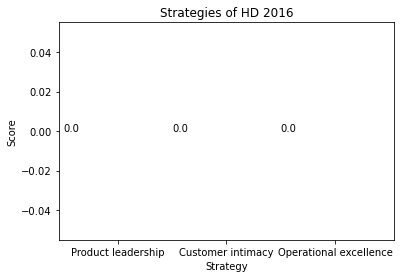

[8, 3, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 16, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 10, 0, 0, 2, 0, 13, 13, 2, 8, 0, 2, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 16, 2, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0]


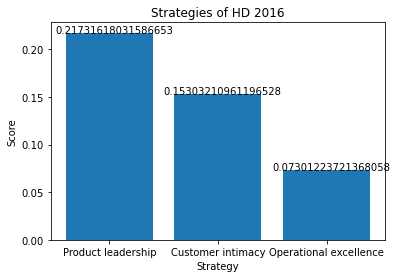

[7, 2, 1, 1, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 15, 0, 0, 6, 2, 15, 15, 2, 3, 0, 6, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 5, 1, 0, 7, 2, 0, 0, 0, 0, 25, 2, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 2, 0]


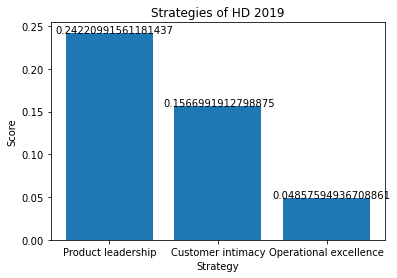

[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 2, 1, 2, 0, 7, 0, 1, 0, 0, 8, 9, 6, 0, 2, 0, 3, 4, 10, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 7, 0, 3, 0, 0, 3, 16, 4, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 12, 0]


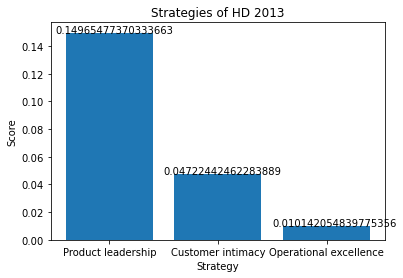

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


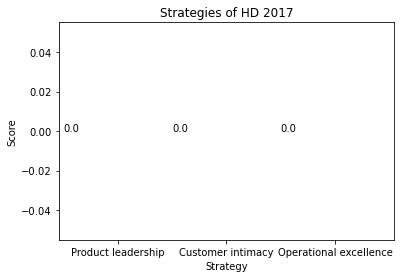

[8, 2, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 14, 0, 0, 4, 2, 14, 14, 2, 3, 0, 4, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 7, 2, 0, 0, 0, 0, 20, 2, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 2, 0]


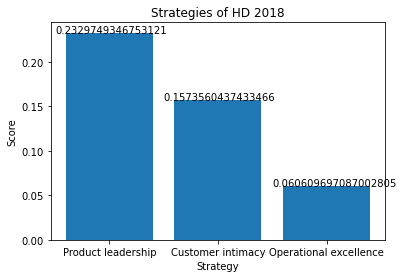

[7, 3, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 11, 0, 0, 2, 0, 14, 9, 2, 15, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 16, 2, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 2, 0]


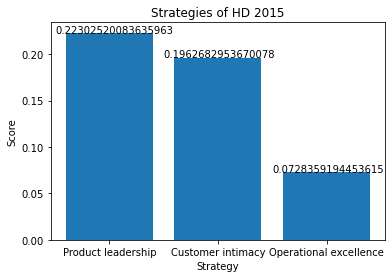

In [234]:
#local directory where all item1 are located
working_dir = '../item1/'
#ticker
ticker = 'HD'


#local directory where all item1 are located
working_dir = '../item1/'
#ticker
ticker = 'HD'

files = os.listdir(working_dir + ticker)
for file in files:
    item1_text = open(working_dir + ticker + '/' + file,'r').read()
    #omit small item1
    if len(item1_text) < 1000:
        continue
    word_counts, word_freq = extract_word_freq(item1_text)    
    print(word_counts)
    P1,P2,P3 = generate_strategy(word_freq)
    year = file.split('-')[1]
    plot_strategy(P1,P2,P3, ticker,year )


[2, 5, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 1, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 5, 2, 0, 6, 7, 8, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


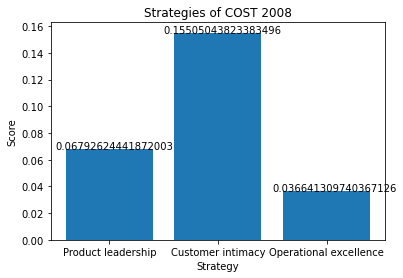

[2, 5, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 5, 2, 0, 7, 4, 6, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


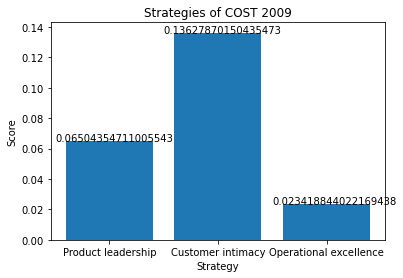

[4, 6, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 1, 5, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 4, 2, 0, 11, 3, 12, 3, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 4, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


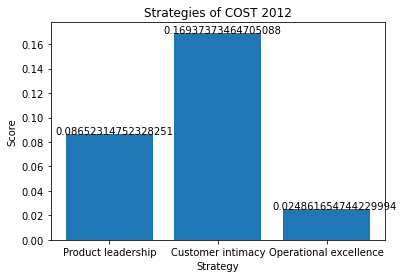

[2, 4, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 5, 2, 0, 6, 7, 7, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


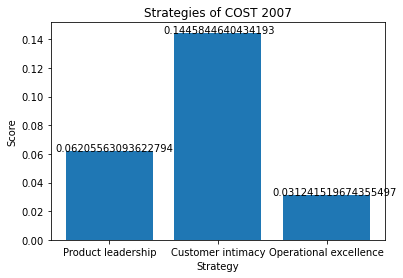

[4, 5, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 5, 2, 0, 10, 3, 9, 1, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


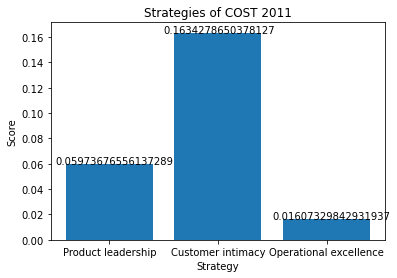

In [236]:
#local directory where all item1 are located
working_dir = '../item1/'
#ticker
ticker = 'COST'

files = os.listdir(working_dir + ticker)
for file in files:
    item1_text = open(working_dir + ticker + '/' + file,'r').read()
    #omit small item1
    if len(item1_text) < 1000:
        continue
    word_counts, word_freq = extract_word_freq(item1_text)    
    print(word_counts)
    P1,P2,P3 = generate_strategy(word_freq)
    year = file.split('-')[1]
    plot_strategy(P1,P2,P3, ticker,year )

[0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 21, 11, 28, 3, 43, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]


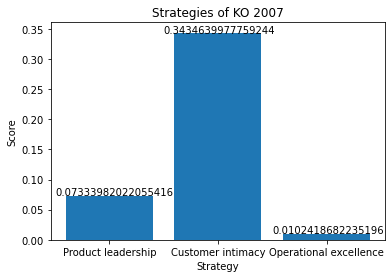

[0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 10, 5, 13, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


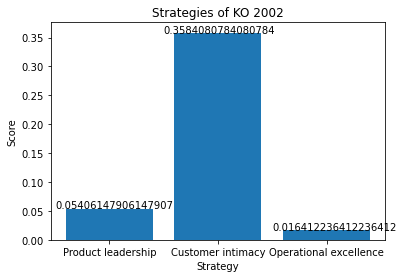

[0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 11, 1, 0, 29, 11, 50, 12, 52, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0]


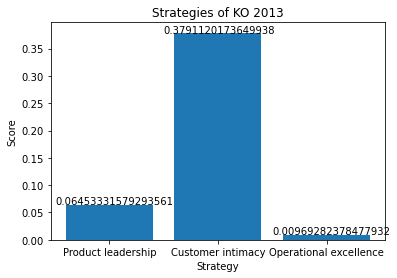

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 17, 3, 29, 0, 38, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]


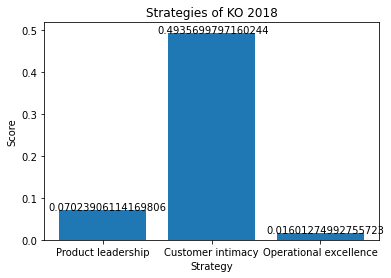

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 6, 1, 0, 25, 12, 31, 4, 48, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0]


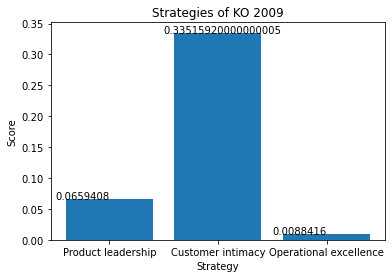

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 24, 11, 29, 3, 45, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0]


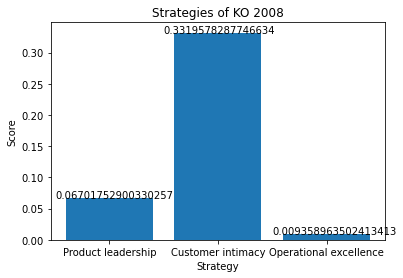

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 18, 3, 21, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]


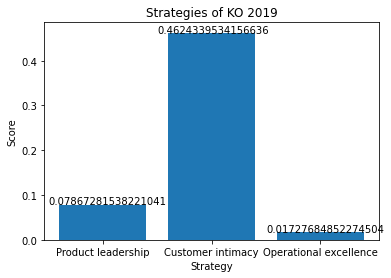

[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 10, 1, 0, 28, 5, 40, 6, 43, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 5, 0]


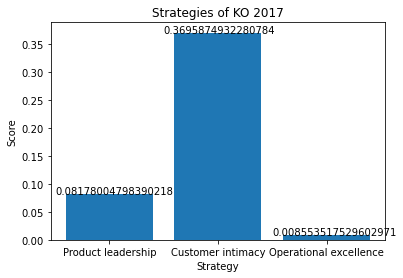

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 4, 4, 2, 0, 36, 11, 12, 0, 39, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


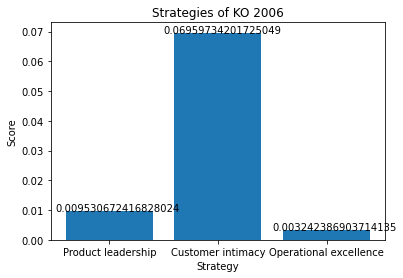

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 17, 7, 18, 0, 46, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


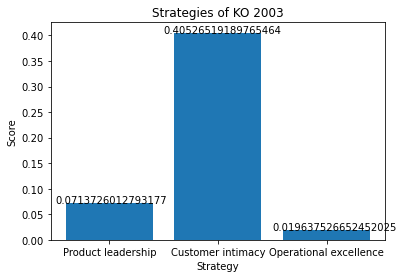

[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 15, 7, 20, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


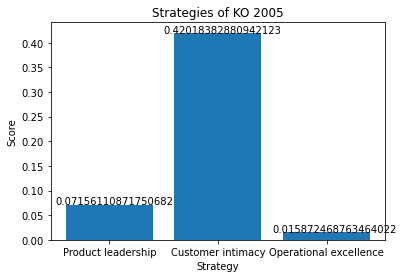

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 6, 1, 0, 27, 11, 44, 7, 52, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 11, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0]


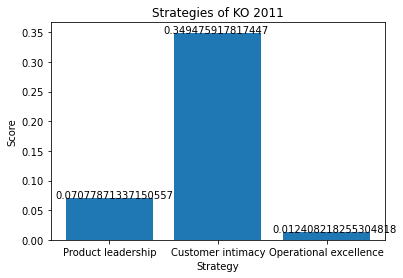

[0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 17, 1, 0, 28, 9, 41, 13, 47, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0]


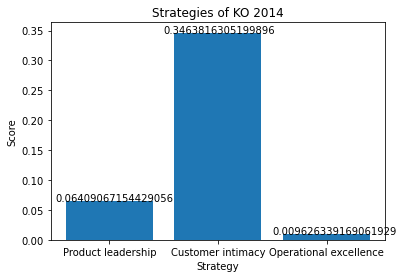

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 17, 4, 21, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


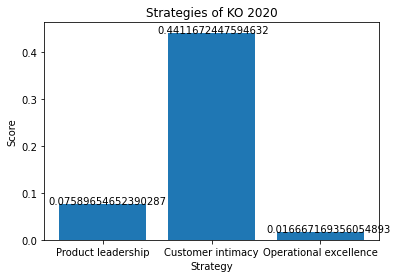

[0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 15, 7, 23, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


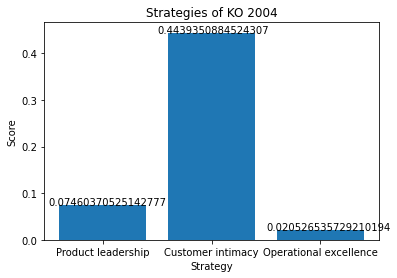

[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 10, 1, 0, 30, 6, 41, 6, 46, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 1, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0]


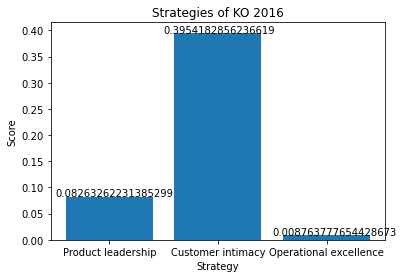

[0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 5, 11, 1, 0, 28, 11, 42, 12, 52, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0]


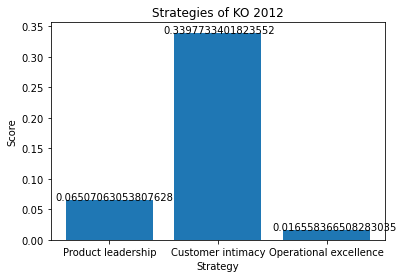

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 18, 4, 26, 1, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 2, 9, 0, 1]


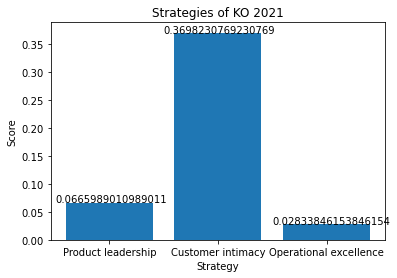

[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 14, 1, 0, 29, 9, 55, 13, 48, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0]


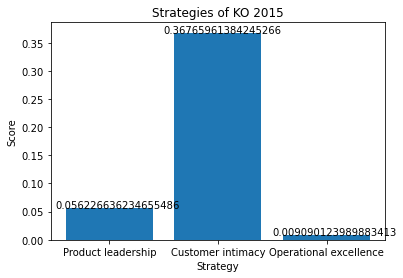

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 3, 7, 1, 0, 25, 12, 34, 5, 55, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0]


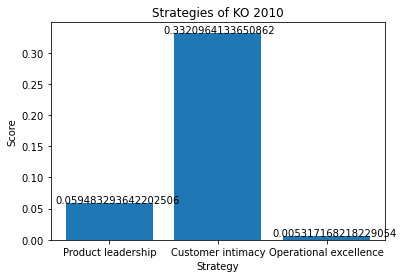

In [238]:
#local directory where all item1 are located
working_dir = '../item1/'
#ticker
ticker = 'KO'

files = os.listdir(working_dir + ticker)
for file in files:
    item1_text = open(working_dir + ticker + '/' + file,'r').read()
    #omit small item1
    if len(item1_text) < 1000:
        continue
    word_counts, word_freq = extract_word_freq(item1_text)    
    print(word_counts)
    P1,P2,P3 = generate_strategy(word_freq)
    year = file.split('-')[1]
    plot_strategy(P1,P2,P3, ticker,year )

In [ ]:
0.17130844155844155 0.05712857142857143 0.00956883116883117